<a href="https://colab.research.google.com/github/lawrencegranda/California-Housing-Prediction/blob/main/predictions_and_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [1]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

!pip install mitdeeplearning
import mitdeeplearning as mdl

# Import all remaining packages
import pandas as pd
import matplotlib.pyplot as plt
import math
from fractions import Fraction
import numpy as np
import os
import time
import seaborn as sns
from tqdm import tqdm
from google.colab import files

#Importing the models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json

import statsmodels.formula.api as smf
from sklearn import linear_model 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from IPython.display import clear_output
clear_output()

### Batch and Loss functions

In [2]:
def get_batch(df, batch_size=1, house_value=False):
    df = df.sample(n=batch_size).reset_index(drop=True)

    median = np.reshape( df['median_house_value'] , [batch_size,] )
    y_batch = np.reshape( df['house_value_index'] , [batch_size,] )
    df = df.drop(columns=['house_value_index', 'median_house_value'])
    x_batch = np.reshape( df , [batch_size,-1] )
    if house_value:  return x_batch, y_batch, pd.DataFrame(median)
    else:       return x_batch, y_batch

def get_input_size(x, verbose=0):
    size = x.shape[1]
    if verbose > 9:
        print(size)
    return size

def compute_loss(y_true, y_pred):
    loss = tf.keras.losses.MeanAbsoluteError()
    return loss(y_true, y_pred)

def compute_accuracy(y_true, y_pred):
    mape = tf.keras.losses.MeanAbsolutePercentageError()
    return (100 - mape(y_true, y_pred).numpy().mean() )
clear_output()

### Getting the Data

(<matplotlib.axes._subplots.AxesSubplot at 0x7f39a9b92a10>,)

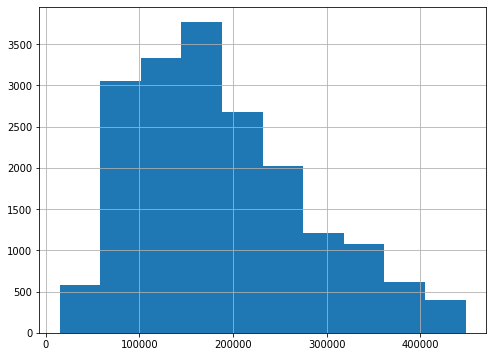

In [3]:
housing_data = pd.concat( [pd.read_csv('/content/sample_data/california_housing_train.csv'), pd.read_csv('/content/sample_data/california_housing_test.csv')], ignore_index=True, sort=False)
data = housing_data[ housing_data['median_house_value'] < 450000 ]

data.reset_index(drop=True, inplace=True)

data['median_house_value'].hist(figsize = (8,6)),

### Feature Engineering

In [4]:
div = 100

latitude = data['latitude']
lat_min = latitude.min()
lat_max = latitude.max()
lat_dif = lat_max- lat_min
lat_step = lat_dif/div

longitude = data['longitude']
lon_min = longitude.min()
lon_max = longitude.max()
lon_dif = lon_max- lon_min
lon_step = lon_dif/div

quadrant = []
map = {}
for i in range(len(data)):
    quad = []
    lon =  data['longitude'][i]
    if lon == lon_min:
        quad.append(0)
    elif lon == lon_max:
        quad.append(div-1)
    else:
        quad.append( math.floor((lon-lon_min)/lon_step) )

    lat =  data['latitude'][i]
    if lat == lat_min:
        quad.append(0)
    elif lat == lat_max:
        quad.append(div-1)
    else:
        quad.append( math.floor((lat-lat_min)/lat_step) )
    quadrant.append(quad)
    if ""+repr(quad) in map:
        map[""+repr(quad)][0] += data['population'][i]
        map[""+repr(quad)][1] += data['households'][i]
        map[""+repr(quad)][2] += 1
        map[""+repr(quad)][3] += data['median_income'][i]
    else:
        map[""+repr(quad)] = []
        map[""+repr(quad)].append( data['population'][i] )
        map[""+repr(quad)].append( data['households'][i] )
        map[""+repr(quad)].append( 1 )
        map[""+repr(quad)].append( data['median_income'][i] )
data['quadrant'] = quadrant
data['quadrant'] = data['quadrant'].astype(str)

data['quad_population'] = np.zeros(len(data))
data['quad_houses'] = np.zeros(len(data))
data['quad_zones'] = np.zeros(len(data))
data['quad_total_income'] = np.zeros(len(data))

for i in range(len(data)):
    data['quad_population'][i] = map[data['quadrant'][i]][0]
    data['quad_houses'][i] = map[data['quadrant'][i]][1]
    data['quad_zones'][i] = map[data['quadrant'][i]][2]
    data['quad_total_income'][i] = map[data['quadrant'][i]][3]
clear_output()

In [5]:
from IPython.core.display import clear_output
data['quad_median_income'] = data['quad_total_income']/data['quad_zones']
data['bed_per_room'] = data['total_bedrooms']/data['total_rooms']
data['room_per_household'] = data['total_rooms']/data['households']
data['bed_per_household'] = data['total_bedrooms']/data['households']
data['room_per_person'] = data['total_rooms']/data['population']
data['people_per_zone'] = data['population']/data['quad_zones']
data['income_per_age'] = data['median_income']/data['housing_median_age']
data['total_income'] = data['median_income']*data['population']
data['total_income_per_house'] = data['total_income']/data['households']
data['total_income_per_bedroom'] = data['total_income']/data['total_bedrooms']
clear_output()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


population                    0.055453
longitude                     0.216898
housing_median_age            0.316926
bed_per_household             0.400799
total_bedrooms                0.686200
people_per_zone               0.746998
households                    1.073875
room_per_household            1.078958
quad_zones                    1.191063
quad_population               1.211044
total_income_per_house        1.585671
total_rooms                   2.237987
room_per_person               2.243118
latitude                      2.289790
total_income_per_bedroom      2.570874
quad_houses                   3.051305
income_per_age                3.813530
bed_per_room                  4.718800
quad_total_income             6.149075
total_income                  7.440086
quad_median_income           32.618281
median_income                41.597320
median_house_value          100.000000
Name: median_house_value, dtype: float64

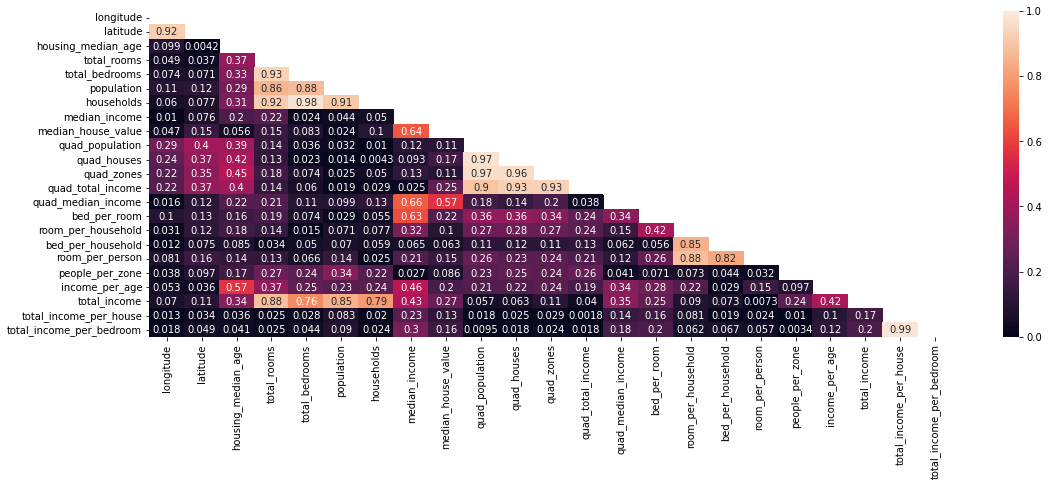

In [6]:
plt.figure(figsize=(18, 6))
mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))
heatmap = sns.heatmap(abs(data.corr()), mask=mask, vmin=0, vmax=1, annot=True)

(data.corr()['median_house_value']**2*100).sort_values()

### Data Normalization / gaussian-like

In [7]:
def gauss(x):
    data1={}
    data1['median_house_value'] = x
    y = x**(1./2)

    dY = y.describe().transpose()
    max = dY['max']
    min = dY['min']
    data1['house_value_index'] = y/(max-min) - min/(max-min)
    return pd.DataFrame(data1)

def de_gauss(data, y):
    data = data['median_house_value']
    data1={}
    data1['house_value_index'] = y

    data2 = data**(1./2)
    dY = data2.describe().transpose()
    max = dY['max']
    min = dY['min']

    x = y * (max-min) + min

    data1['median_house_value'] = x**(2)
    return pd.DataFrame(data1)   

In [8]:
data_upd = data
median_house_value = data_upd['median_house_value']
longitude = data_upd['longitude']
latitude = data_upd['latitude']

data_upd = data.drop([ 'median_house_value', 'quadrant'], axis=1)
data_upd.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,quad_population,quad_houses,...,quad_median_income,bed_per_room,room_per_household,bed_per_household,room_per_person,people_per_zone,income_per_age,total_income,total_income_per_house,total_income_per_bedroom
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,1015.0,472.0,...,1.493600,0.228617,11.889831,2.718220,5.529064,1015.000000,0.099573,1516.0040,3.211873,1.181609
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,1129.0,463.0,...,1.820000,0.248497,16.522678,4.105832,6.775908,1129.000000,0.095789,2054.7800,4.437970,1.080894
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,333.0,117.0,...,1.650900,0.241667,6.153846,1.487179,2.162162,333.000000,0.097112,549.7497,4.698715,3.159481
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,10892.0,3657.0,...,2.553014,0.224517,6.641593,1.491150,2.914563,73.571429,0.227979,1643.7255,7.273122,4.877524
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,624.0,262.0,...,1.925000,0.224209,5.549618,1.244275,2.330128,624.000000,0.096250,1201.2000,4.584733,3.684663


In [9]:
from sklearn.preprocessing import QuantileTransformer 
scaler1 = QuantileTransformer(output_distribution='normal')

columns_scaled = scaler1.fit_transform(data_upd)
new_data1 = pd.DataFrame(columns_scaled, columns=data_upd.columns, index = data_upd.index)


from sklearn.preprocessing import MinMaxScaler
scaler2 = MinMaxScaler()

columns = new_data1.values
columns_scaled = scaler2.fit_transform(columns)
new_data = pd.DataFrame(columns_scaled, columns=new_data1.columns, index = new_data1.index)

from sklearn.preprocessing import MinMaxScaler
scaler3 = MinMaxScaler()

columns = data_upd[['longitude', 'latitude']]
columns_scaled = scaler3.fit_transform(columns)
coords_col = pd.DataFrame(columns_scaled, columns=columns.columns, index = data_upd.index)

new_data['longitude'] = coords_col['longitude']
new_data['latitude'] = coords_col['latitude']

new_data['house_value_index'] = gauss(median_house_value)['house_value_index']
new_data['median_house_value'] = gauss(median_house_value)['median_house_value'] 

In [10]:
new_data_copy = new_data
new_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,quad_population,quad_houses,...,room_per_household,bed_per_household,room_per_person,people_per_zone,income_per_age,total_income,total_income_per_house,total_income_per_bedroom,house_value_index,median_house_value
count,18738.000000,18738.000000,18738.000000,18738.000000,18738.000000,18738.000000,18738.000000,18738.000000,18738.000000,18738.000000,...,18738.000000,18738.000000,18738.000000,18738.000000,18738.000000,18738.000000,18738.000000,18738.000000,18738.000000,18738.000000
mean,0.477385,0.330846,0.516547,0.500000,0.499976,0.499982,0.499966,0.499928,0.503889,0.503857,...,0.499987,0.499988,0.499983,0.499978,0.499967,0.499989,0.499988,0.499978,0.544639,187837.922724
std,0.199778,0.228949,0.142868,0.096160,0.096227,0.096175,0.096272,0.096584,0.110127,0.110245,...,0.096144,0.096141,0.096162,0.096150,0.096247,0.096198,0.096134,0.096160,0.192363,91477.602314
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14999.000000
25%,0.259960,0.147715,0.435968,0.435061,0.435061,0.435046,0.435213,0.435213,0.434910,0.435213,...,0.435118,0.435172,0.435153,0.435156,0.435067,0.435124,0.435116,0.435177,0.397618,115600.000000
50%,0.582669,0.183847,0.498070,0.499960,0.500121,0.499879,0.499879,0.500006,0.499638,0.499879,...,0.500054,0.499954,0.499979,0.500005,0.500015,0.500012,0.500004,0.499997,0.533332,171600.000000
75%,0.633466,0.551541,0.566769,0.564937,0.564787,0.564917,0.564934,0.564841,0.564183,0.565394,...,0.564899,0.564846,0.564888,0.564865,0.564832,0.564862,0.564896,0.564808,0.677564,243200.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,448300.000000


### Dimensionality Reduction (PCA)

#### Analysis

<function IPython.core.display.clear_output(wait=False)>

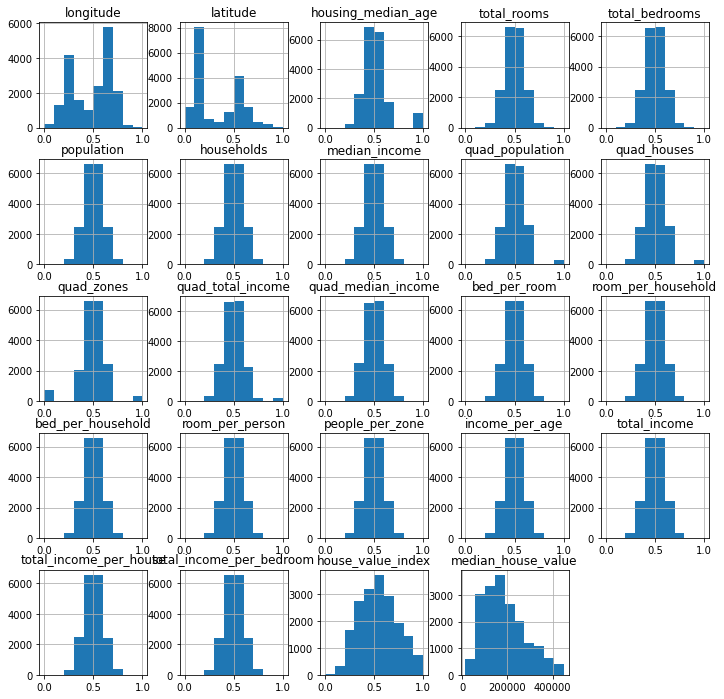

In [11]:
new_data.hist(figsize = (12,12))
clear_output

<function IPython.core.display.clear_output(wait=False)>

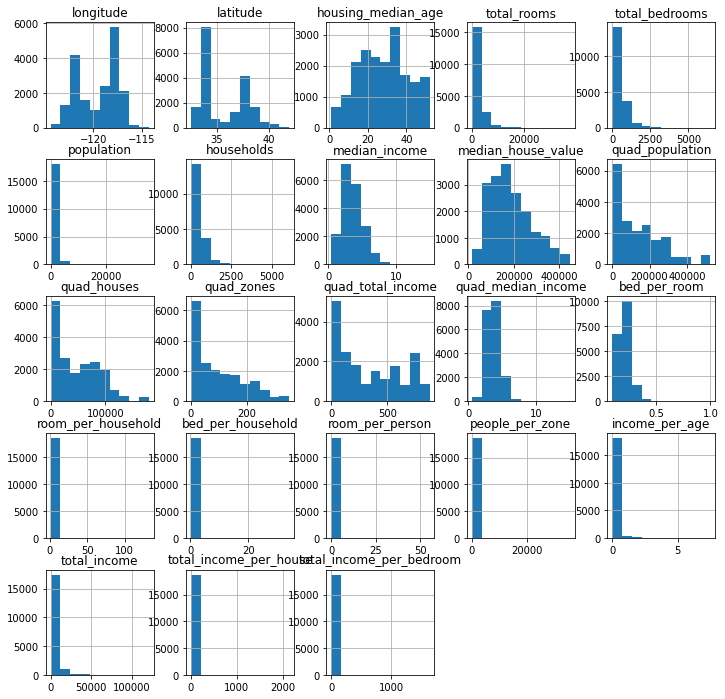

In [12]:
data.hist(figsize = (12,12))
clear_output

<function IPython.core.display.clear_output(wait=False)>

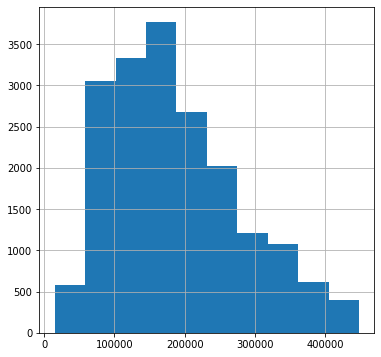

In [13]:
new_data['median_house_value'].hist(figsize = (6,6))
clear_output

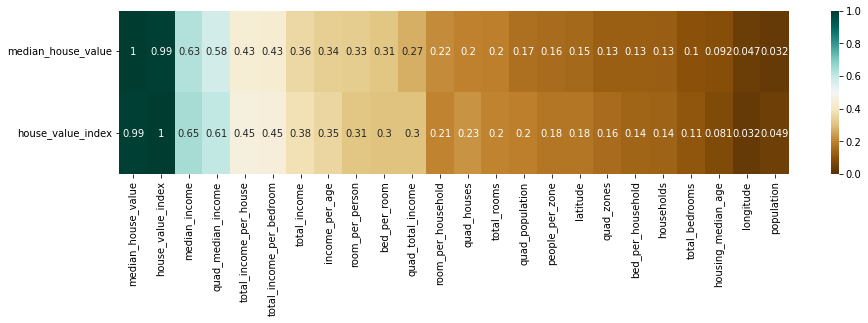

In [14]:
new_corr1 = pd.DataFrame(abs(new_data.corr()['median_house_value']).sort_values(ascending=False))
new_corr2 = pd.DataFrame(abs(new_data.corr()['house_value_index']).sort_values(ascending=False))

plt.figure(figsize=(15, 3))
heatmap = sns.heatmap(abs(new_data.corr()[['median_house_value', 'house_value_index']]).sort_values(by='median_house_value', ascending=False).transpose(), vmin=0, vmax=1, annot=True, cmap='BrBG')

heatmap

##### Pairplot of correlation

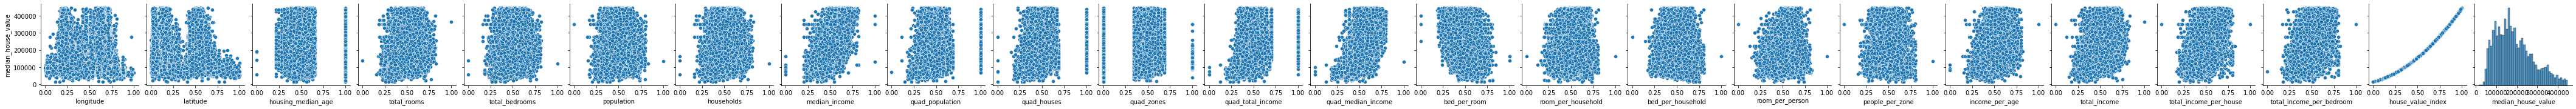

In [15]:
scatter_data = new_data.copy()
pp = sns.pairplot(data=scatter_data,
                  y_vars=['median_house_value'],
                  x_vars=scatter_data.columns,
                  )

#### Models and data

##### imports


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_absolute_error
!pip install scikit-plot
import scikitplot as skplt
clear_output()

##### custom model

In [17]:
def getOptimizer(strOptimizer='adam', learning_rate=0.05):
    optimizer_options = {
                            "adam" :        tf.keras.optimizers.Adam(learning_rate),
                            "adagrad" :     tf.keras.optimizers.Adagrad(learning_rate),
                            "adadelta" :    tf.keras.optimizers.Adadelta(learning_rate),
                            "adamax" :      tf.keras.optimizers.Adamax(learning_rate),
                            "ftrl" :        tf.keras.optimizers.Ftrl(learning_rate),
                            "nadam" :       tf.keras.optimizers.Nadam(learning_rate),
                            "RMSprop" :     tf.keras.optimizers.RMSprop(learning_rate),
                        }
    return optimizer_options[strOptimizer]

In [18]:
def buildModel(input_size, batch_size=1000, verbose=0, optimizer='adam', learning_rate=0.05):
    model = Sequential()
    model.add(Input(shape=input_size, batch_size=batch_size))
    model.add(Dense(units=3, activation='relu'))
    model.add(Dense(units=1, activation='linear'))

    if verbose >0:
        model.summary()
    elif verbose <0:
        clear_output()

    model.compile   (   
                        loss=tf.keras.losses.MeanAbsoluteError(),
                        optimizer=getOptimizer(optimizer, learning_rate),
                    ) 
    return model

##### model selection

In [19]:
pca_data = new_data.copy()
pca_data = pca_data.sample(frac=1).reset_index(drop=True)

In [20]:
def makeCurves(true, y, pred):
    fig, axes = plt.subplots(1,2, figsize = (8,3))


    pred_value = pred['median_house_value']
    plt.sca(axes[0])
    plt.scatter(true, pred_value, c='crimson')
    plt.yscale('log')
    plt.xscale('log')

    p1 = max(max(pred_value), max(true))
    p2 = min(min(pred_value), min(true))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True House Value', fontsize=10)
    plt.ylabel('Value Predictions', fontsize=10)
    plt.axis('equal')
    axes[0].grid(True)


    pred_index = pred['house_value_index']
    plt.sca(axes[1])
    plt.scatter(y, pred_index, c='crimson')
    plt.yscale('log')
    plt.xscale('log')

    p1 = max(max(pred_index), max(y))
    p2 = min(min(pred_index), min(y))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Value Index', fontsize=10)
    plt.ylabel('Index Predictions', fontsize=10)
    plt.axis('equal')
    axes[1].grid(True)

    fig.tight_layout()
    plt.show()

In [21]:
def buildRegression(data, verbose=1, regressor='linear', deg=2, optimizer='adam', mask='none'):
    train, test = data[:16000].reset_index(drop=True), data[16000:].reset_index(drop=True)
    x_train, y_train = get_batch(train, len(train)-1, False)
    batch_size = 750

    if verbose > 0 :
        print('Building Regressor Model...')
    if verbose >9:
        print(x_train.head(), x_train.shape)

    if regressor == 'forest':
        model = RandomForestRegressor(n_estimators=10, max_depth=100).fit(x_train, y_train)
    elif regressor == 'bayesian':
        model = linear_model.BayesianRidge().fit(x_train, y_train)
    elif regressor == 'SGD':
        model = linear_model.SGDRegressor(max_iter=1000, tol=1e-3).fit(x_train, y_train)
    elif regressor == 'passiveAgressive':
        model = linear_model.PassiveAggressiveRegressor(max_iter=100, random_state=0, tol=1e-3).fit(x_train, y_train)
    else:
         model = LinearRegression().fit(x_train, y_train)

    if mask == 'polynomial' or mask == 'poly':
        model = Pipeline([  ('poly', PolynomialFeatures(degree=deg)),
                            ('model', model)]).fit(x_train, y_train)
                
    metric = predModel(model, data, test, verbose-1)
    if verbose > 0 :
        print('True MAE: {:.0f}'.format(metric['True_MAE']))
    if verbose > 1 :
        print('Normalized MAE: {:.3f}'.format(metric['Normalized_MAE']))

    return model, metric


def predModel(model, dataSet, test, verbose=0, regressor='None'):
    x_test, y_test, true_value = get_batch(test, len(test.to_numpy())-5, True)

    pred = model.predict(x_test)
    if verbose > 9:
        print(pred)
    mae1 = mean_absolute_error(y_test, pred)
    
    pred_value = de_gauss(dataSet, pred)
    mae2 = mean_absolute_error(true_value['median_house_value'], pred_value['median_house_value'])

    if verbose>0:
        makeCurves(true_value['median_house_value'],y_test, pred_value)
    metric = {'True_MAE' : mae2, 'Normalized_MAE' : mae1}
    return metric

In [22]:
def buildPCA(data, components=1, verbose=1, regressor='linear', deg=2, optimizer='adam', mask='none'):
    if verbose >=1:
        print('Building PCA...')

    x, y, value = get_batch(data, len(data)-1, True)
    x_train, y_train = get_batch(data, math.floor(len(data)*0.8), False)

    myPCA = PCA(n_components=components).fit(x_train)
    x_PCA = pd.DataFrame(myPCA.transform(x))
    data_PCA = x_PCA.join(y).join(value)

    model, metric = buildRegression(data_PCA, verbose=verbose, regressor=regressor, deg=deg, mask=mask)
    return myPCA, metric

#### Zones

In [23]:
from sklearn.cluster import KMeans
new_data_cluster = new_data_copy.copy()
zones = 100

cluster_zone = new_data_cluster[['longitude', 'latitude']].to_numpy()
kmeans = KMeans(n_clusters=zones).fit(cluster_zone)

new_data_cluster['zone'] = kmeans.labels_
columns = []
columns.append(['zone'+repr(i+1) for i in range(zones)])
columns = np.array(columns)
columns = np.squeeze(columns)
print(repr(columns))
x_clusters = pd.DataFrame(pd.get_dummies(new_data_cluster['zone']).to_numpy())
x_clusters.columns = columns
new_data_cluster = new_data_cluster.drop(columns='zone', axis=1)
new_data_cluster = pd.concat([new_data_cluster, x_clusters], axis=1)

clear_output()

clusterColumns = columns.copy()
clusterColumns = np.append(clusterColumns,'median_house_value')
clusterColumns = np.append(clusterColumns,'house_value_index')


clusteringData = pd.DataFrame(new_data_cluster[clusterColumns])
clusteringData.head(3)

,zone1,zone2,zone3,zone4,zone5,zone6,zone7,zone8,zone9,zone10,...,zone93,zone94,zone95,zone96,zone97,zone98,zone99,zone100,median_house_value,house_value_index
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,66900.0,0.248921
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,80100.0,0.293464
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,85700.0,0.311243


In [24]:
import plotly.express as px
px.scatter(x=new_data_copy['longitude'], y=new_data_copy['latitude'], color= kmeans.labels_, width=500, height=300)

/usr/local/lib/python3.7/dist-packages/tornado/httputil.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class HTTPHeaders(collections.MutableMapping):


Building Regressor Model...


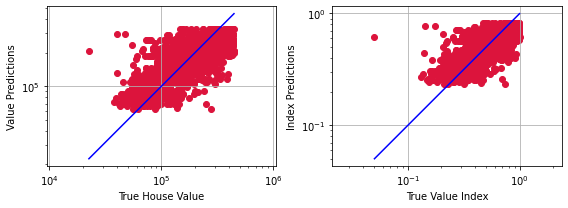

True MAE: 48376
Normalized MAE: 0.101


In [25]:
RegressionModelClustering, metric = buildRegression(clusteringData, verbose=2, regressor='bayesian', mask='none', deg=3)

### Building Model

In [26]:
data_model = new_data[['quad_houses','quad_population', 'quad_total_income',
                       'bed_per_household' , 'room_per_person' , 'room_per_household',
                       'total_income_per_house' , 'total_income_per_bedroom',
                       'income_per_age', 'quad_median_income' , 'median_income',
                       'total_income', 'latitude' , 'longitude']].copy()
data_target = new_data[[ 'house_value_index','median_house_value' ]].copy()

In [27]:
from sklearn.cluster import KMeans
new_data_cluster = data_model.copy()
zones = 100

cluster_zone = new_data_cluster[['longitude', 'latitude']].to_numpy()
kmeans = KMeans(n_clusters=zones).fit(cluster_zone)

new_data_cluster['zone'] = kmeans.labels_
columns = []
columns.append(['zone'+repr(i+1) for i in range(zones)])
columns = np.array(columns)
columns = np.squeeze(columns)
print(repr(columns))
x_clusters = pd.DataFrame(pd.get_dummies(new_data_cluster['zone']).to_numpy())
x_clusters.columns = columns
new_data_cluster = new_data_cluster.drop(columns='zone', axis=1)
new_data_cluster = pd.concat([new_data_cluster, x_clusters], axis=1)
new_data_cluster = pd.concat([new_data_cluster, data_target], axis=1)

clear_output()
data_ready = pd.DataFrame(new_data_cluster.copy())
data_ready.head(2)

,quad_houses,quad_population,quad_total_income,bed_per_household,room_per_person,room_per_household,total_income_per_house,total_income_per_bedroom,income_per_age,quad_median_income,...,zone93,zone94,zone95,zone96,zone97,zone98,zone99,zone100,house_value_index,median_house_value
0,0.327868,0.316764,0.223500,0.736835,0.737338,0.733462,0.303283,0.238192,0.469239,0.230588,...,0,0,0,0,0,0,0,0,0.248921,66900.0
1,0.327030,0.320856,0.254465,0.759440,0.748883,0.747379,0.355272,0.232617,0.463546,0.278353,...,0,0,0,0,0,0,0,0,0.293464,80100.0


Building Regressor Model...


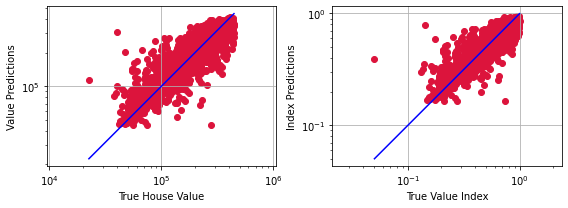

True MAE: 28063
Normalized MAE: 0.059


In [28]:
myModel, metric = buildRegression(data_ready, verbose=3, regressor='forest', mask='none', deg=3)